In [1]:
import sys
import os

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider

import numpy as np
import pandas as pd
import sqlite3
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [4]:
connection = sqlite3.connect("../../mlos_exp.db")
cursor = connection.cursor()

In [5]:
env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")

In [6]:
env_table

,empty_reads,non_empty_reads,range_queries,writes,entry_size,selectivity,entries_per_page,num_elmement,bits_per_elem_max,read_write_asym
env_id,,,,,,,,,,
1,0.325,0.008,0.603,0.064,8192,7.273693e-09,4,954120869,13.452259,1.0
2,0.367,0.025,0.423,0.185,4096,5.776132e-08,16,223195585,10.190155,1.0
3,0.037,0.149,0.620,0.194,8192,3.906935e-08,16,491620285,14.781112,1.0
4,0.037,0.894,0.064,0.005,4096,2.366244e-09,16,134660293,9.438230,1.0
5,0.022,0.023,0.151,0.804,8192,6.209708e-08,16,266529776,18.719444,1.0
...,...,...,...,...,...,...,...,...,...,...
96,0.402,0.067,0.499,0.032,4096,3.655311e-08,8,191533216,12.580383,1.0
97,0.159,0.180,0.239,0.422,4096,9.955587e-08,8,257638343,19.072468,1.0
98,0.856,0.075,0.037,0.032,2048,4.765053e-08,32,575595644,14.964177,1.0


In [7]:
run_table

,env_id,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,kap5,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
idx,,,,,,,,,,,,,,,,,,,,,
1,1,0,8.717489,22,8.0,29.0,4.0,3.0,24.0,29.0,...,5.0,16.0,24.0,19.0,11.0,17.0,15.0,30.0,2.0,24.517375
2,1,1,3.869621,6,19.0,5.0,23.0,26.0,14.0,13.0,...,25.0,10.0,1.0,4.0,23.0,7.0,21.0,15.0,16.0,43.732326
3,1,2,5.618778,11,1.0,18.0,8.0,16.0,16.0,8.0,...,17.0,5.0,16.0,15.0,25.0,12.0,28.0,2.0,12.0,17.356313
4,1,3,13.120336,27,26.0,9.0,27.0,8.0,7.0,22.0,...,13.0,30.0,9.0,30.0,7.0,27.0,7.0,17.0,28.0,38.907877
5,1,4,11.725097,19,4.0,2.0,16.0,14.0,3.0,16.0,...,10.0,20.0,22.0,11.0,27.0,4.0,26.0,22.0,8.0,13.412227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,100,95,4.323648,11,1.0,4.0,1.0,3.0,2.0,21.0,...,19.0,2.0,1.0,27.0,18.0,20.0,6.0,6.0,16.0,4.243794
9997,100,96,2.634468,10,3.0,4.0,2.0,10.0,2.0,19.0,...,13.0,2.0,1.0,20.0,21.0,16.0,6.0,9.0,12.0,3.806153
9998,100,97,3.345606,10,3.0,4.0,2.0,21.0,1.0,18.0,...,15.0,1.0,9.0,26.0,27.0,17.0,4.0,7.0,11.0,3.774388


# Load in LTune Model

In [8]:
path = '/scratchNVMe/ndhuynh/other_data/models/ltune/klsm_med2'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
cf = EndureCost(config)
design_type = getattr(Policy, config["lsm"]["design"])
bounds = LSMBounds(**config["lsm"]["bounds"])

In [9]:
model = LTuneModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["ltune"]["model"],
).build_model(design_type)
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_20.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [10]:
ltune_util = LTuneEvalUtil(config, model, design_type)

## Example of how to evaluate ltune

In [11]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)

# Plotting Experiments


1. Train a LTune model
2. Start with a clean BO model
3. Pick a workload, w, that both models have not seen
4. Train BO model, while capturing the designs at each round (round <- (suggest, cost, register))
5. Plot performance of each round, and the performance of a single LTune suggestion for w

## Parameters

Change run_id to look at a different environment setup

In [56]:
def add_learned_tunings(cursor: sqlite3.Cursor) -> None:
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS learned_tunings (
            env_id INTEGER PRIMARY KEY AUTOINCREMENT,
            bits_per_elem REAL,
            size_ratio INTEGER,
            kap0 REAL, kap1 REAL, kap2 REAL, kap3 REAL, kap4 REAL,
            kap5 REAL, kap6 REAL, kap7 REAL, kap8 REAL, kap9 REAL,
            kap10 REAL, kap11 REAL, kap12 REAL, kap13 REAL, kap14 REAL,
            kap15 REAL, kap16 REAL, kap17 REAL, kap18 REAL, kap19 REAL,
            cost REAL,
            FOREIGN KEY (env_id) REFERENCES workloads(env_id)
        );
        """
    )
    wl_cols = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
    sys_cols = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']
    for (env_id,) in cursor.execute("SELECT env_id FROM environments"):
        env = env_table.query(f'env_id == {env_id}')
        data = run_table.query(f'env_id == {env_id}')
        wl = Workload(*env[wl_cols].values[0])
        system = System(*env[sys_cols].values[0])
        
        out = ltune_util.get_ltune_out(system, wl.z0, wl.z1, wl.q, wl.w)
        ltune_design = ltune_util.convert_ltune_output(out)
        ltune_cost = cf.calc_cost(ltune_design, system, wl.z0, wl.z1, wl.q, wl.w)
        cursor.execute(
            """
            INSERT OR REPLACE INTO learned_tunings (
            env_id,
            bits_per_elem,
            size_ratio,
            kap0, kap1, kap2, kap3, kap4,
            kap5, kap6, kap7, kap8, kap9,
            kap10, kap11, kap12, kap13, kap14,
            kap15, kap16, kap17, kap18, kap19,
            cost
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,? ,? ,? ,?, ?, ?)
            """,
            (env_id, ltune_design.h, int(ltune_design.T)) + tuple(ltune_design.K) + (ltune_cost,)
        )
    ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", connection, index_col="env_id")
    connection.commit()
    
    return ltune_table

In [ ]:
ltune_table = add_learned_tunings(cursor)

In [57]:
def plot_env(env_id: int = 1):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    # ltune = ltune_table.query(f'env_id == {env_id')
    wl_cols = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
    sys_cols = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']
    wl = Workload(*env[wl_cols].values[0])
    system = System(*env[sys_cols].values[0])
    
    out = ltune_util.get_ltune_out(system, wl.z0, wl.z1, wl.q, wl.w)
    ltune_design = ltune_util.convert_ltune_output(out)
    ltune_cost = cf.calc_cost(ltune_design, system, wl.z0, wl.z1, wl.q, wl.w)
    
    x, y = data['round'].values, data['cost'].values
    
    fig, ax = plt.subplots()
    ax.plot(x, y, label='Bayesian Optimizer', color='tab:gray', marker='o')
    ax.hlines(y=ltune_cost, xmin=0, xmax=data['round'].values.max(), label='LTune', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, ltune_design, wl, system

In [23]:
id_widget = IntSlider(min=1, max=100, step=1)
iplot = interactive(plot_env, env_id=id_widget)
iplot

interactive(children=(IntSlider(value=1, description='env_id', min=1), Output()), _dom_classes=('widget-intera…

In [14]:
iplot.result

(1,
 LSMDesign(h=0.4215482473373413, T=27, policy=<Policy.KHybrid: 3>, Q=1.0, Y=1.0, Z=1.0, K=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 Workload(z0=0.325, z1=0.008000000000000007, q=0.603, w=0.06399999999999995),
 System(E=8192.0, s=7.273692678982164e-09, B=4.0, N=954120869.0, H=13.452259319538351, phi=1.0))

# Analyzing Trends

1. Finding the CDF of when BO is better than LTune

In [30]:
sql_query = """
    SELECT
        t.env_id,
        MIN(t.round) as min_round
    FROM tunings t
    INNER JOIN learned_tunings lt ON t.env_id = lt.env_id
    WHERE t.cost < lt.cost
    GROUP BY t.env_id;
    """
df = pd.read_sql(sql_query, connection)
data = df['min_round'].values
data = np.concatenate([data, [float('inf') for _ in range(100 - len(data))]])

In [31]:
data

array([40., 36., 49.,  3., 48., 29., 40., 55., 22., 43.,  0.,  1., 38.,
       87., 15., 59., 54., 52., 75., 62., 53., 54.,  0., 63., 66., 57.,
       18., 55.,  1., 58.,  1., 55., 70., 45., 25., 60., 76., 77.,  3.,
       54., 43., 62., 56., 57., 82.,  7., 39., 47., 93., 42., 76., 57.,
       87., 85.,  0., 42., 48., 30., 72., 92., 21., 43.,  4., 41., 37.,
       55., 41.,  1.,  1., 97., 31., 75., 52., 39., 50., 68., 27., 35.,
        1., 57., 31., 79., 65., 55.,  0., 31., 48.,  5., 64., 45., 56.,
       51., 80., inf, inf, inf, inf, inf, inf, inf])

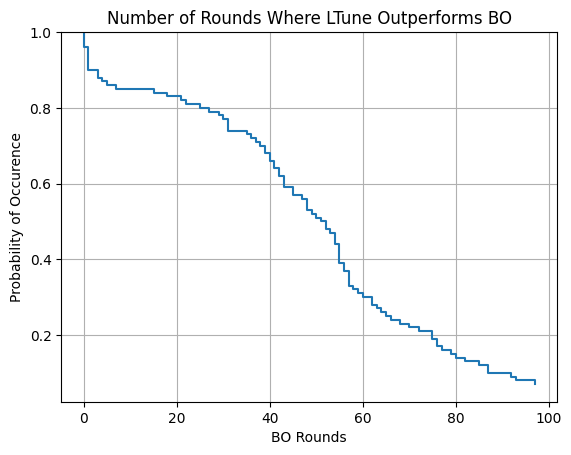

In [32]:
fig, ax = plt.subplots()
ax.ecdf(data, label="CDF", complementary=True)
ax.set_xlabel("BO Rounds")
ax.set_ylabel("Probability of Occurence")
ax.set_title("Number of Rounds Where LTune Outperforms BO")
ax.grid()
plt.show()